In [2]:
import pandas as pd

# Load the CSV file
file_path = r"C:\Users\keerthana\Downloads\CA_Weather_Fire_Dataset_1984-2025.csv"
df = pd.read_csv(file_path)

# Remove rows with NaN values
df_cleaned = df.dropna()

# Save the cleaned dataset
cleaned_file_path = r"cleanednan.csv"
df_cleaned.to_csv(cleaned_file_path, index=False)

print(f"Cleaned file saved at: {cleaned_file_path}")


Cleaned file saved at: cleanednan.csv


In [3]:
import pandas as pd

# Load the dataset
file_path = r"cleanednan.csv"
df = pd.read_csv(file_path)

# Encode SEASON
season_mapping = {
    'Winter': 1,
    'Spring': 2,
    'Summer': 3,
    'Fall': 4
}
df['SEASON'] = df['SEASON'].map(season_mapping)

# Encode FIRE_START_DAY (True -> 1, False -> 0)
df['FIRE_START_DAY'] = df['FIRE_START_DAY'].astype(int)

# Save the updated dataset
encoded_file_path = r"encnan.csv"
df.to_csv(encoded_file_path, index=False)

print(f"Encoded file saved at: {encoded_file_path}")


Encoded file saved at: encnan.csv


In [4]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Load the encoded dataset
file_path = r"encnan.csv"
df = pd.read_csv(file_path)

# Columns to normalize
columns_to_normalize = [
    "PRECIPITATION", "MAX_TEMP", "MIN_TEMP", "AVG_WIND_SPEED", 
    "TEMP_RANGE", "WIND_TEMP_RATIO", "LAGGED_PRECIPITATION", "LAGGED_AVG_WIND_SPEED"
]

# Initialize the MinMaxScaler with feature range 1 to 100
scaler = MinMaxScaler(feature_range=(1, 100))

# Normalize the selected columns
df[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])

# Save the normalized dataset
normalized_file_path = r"final.csv"
df.to_csv(normalized_file_path, index=False)

print(f"Normalized file saved at: {normalized_file_path}")


Normalized file saved at: final.csv


In [30]:
import pandas as pd
import numpy as np
import optuna
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.metrics import accuracy_score, classification_report
from imblearn.combine import SMOTEENN

# Load dataset
df = pd.read_csv(r"final.csv")

# Feature selection
features = ["DATE", "PRECIPITATION", "MAX_TEMP", "MIN_TEMP", "AVG_WIND_SPEED", "YEAR", 
            "TEMP_RANGE", "WIND_TEMP_RATIO", "MONTH", "SEASON", "LAGGED_PRECIPITATION", 
            "LAGGED_AVG_WIND_SPEED", "DAY_OF_YEAR"]
target = "FIRE_START_DAY"

# Convert DATE to datetime format (YYYY-MM-DD is automatically recognized)
df['DATE'] = pd.to_datetime(df['DATE'], errors='coerce')

# Drop rows where DATE conversion failed (NaT values)
df = df.dropna(subset=['DATE'])

# Convert DATE to ordinal (days since Jan 1, 2000)
df['DATE'] = df['DATE'].map(lambda x: x.toordinal() - pd.to_datetime('2000-01-01').toordinal())



# Define X and y
X = df[features]
y = df[target]

# Scale data


X_df = pd.DataFrame(X, columns=features)

# Handle class imbalance
smote_enn = SMOTEENN(random_state=42)
X_resampled, y_resampled = smote_enn.fit_resample(X_df, y)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

# Hyperparameter tuning function
def objective(trial):
    xgb_params = {
        "n_estimators": trial.suggest_int("xgb_n_estimators", 50, 500),  # Increased upper limit
        "learning_rate": trial.suggest_float("xgb_learning_rate", 0.005, 0.2),
        "max_depth": trial.suggest_int("xgb_max_depth", 3, 10),
        "subsample": trial.suggest_float("xgb_subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("xgb_colsample_bytree", 0.6, 1.0),
        "random_state": 42,
        "tree_method": "hist",
        "device": "cuda"
    }
    
    rf_params = {
        "n_estimators": trial.suggest_int("rf_n_estimators", 50, 300),  # Increased range
        "max_depth": trial.suggest_int("rf_max_depth", 3, 12),
        "min_samples_split": trial.suggest_int("rf_min_samples_split", 2, 20),
        "min_samples_leaf": trial.suggest_int("rf_min_samples_leaf", 1, 10),
        "random_state": 42,
        "n_jobs": -1
    }
    
    lgb_params = {
        "n_estimators": trial.suggest_int("lgb_n_estimators", 50, 500),
        "learning_rate": trial.suggest_float("lgb_learning_rate", 0.005, 0.2),
        "max_depth": trial.suggest_int("lgb_max_depth", 3, 10),
        "min_child_samples": trial.suggest_int("lgb_min_child_samples", 5, 40),
        "num_leaves": trial.suggest_int("lgb_num_leaves", 10, 50),
        "random_state": 42,
        "n_jobs": -1,
        "verbosity": -1
    }

    xgb = XGBClassifier(**xgb_params)
    rf = RandomForestClassifier(**rf_params)
    lgb = LGBMClassifier(**lgb_params)

    stacking = StackingClassifier(
        estimators=[('xgb', xgb), ('rf', rf), ('lgb', lgb)],
        final_estimator=XGBClassifier(
            n_estimators=100,  # Increased from 30 to 100
            learning_rate=0.05,
            max_depth=5,
            random_state=42,
            tree_method='hist',
            device='cuda'
        ),
        cv=5,  # Increased cross-validation folds for stability
        n_jobs=-1
    )

    stacking.fit(X_train, y_train)
    y_pred = stacking.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy  

# Run Optuna hyperparameter tuning
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)  # Increased trials for better search

# Get best parameters
best_params = study.best_params
print("Best parameters:", best_params)
print(f"Best accuracy from tuning: {study.best_value:.4f}")

# Train final models with best hyperparameters
xgb = XGBClassifier(
    n_estimators=best_params["xgb_n_estimators"],
    learning_rate=best_params["xgb_learning_rate"],
    max_depth=best_params["xgb_max_depth"],
    subsample=best_params["xgb_subsample"],
    colsample_bytree=best_params["xgb_colsample_bytree"],
    random_state=42,
    tree_method="hist",
    device="cuda"
)
rf = RandomForestClassifier(
    n_estimators=best_params["rf_n_estimators"],
    max_depth=best_params["rf_max_depth"],
    min_samples_split=best_params["rf_min_samples_split"],
    min_samples_leaf=best_params["rf_min_samples_leaf"],
    random_state=42,
    n_jobs=-1
)
lgb = LGBMClassifier(
    n_estimators=best_params["lgb_n_estimators"],
    learning_rate=best_params["lgb_learning_rate"],
    max_depth=best_params["lgb_max_depth"],
    min_child_samples=best_params["lgb_min_child_samples"],
    num_leaves=best_params["lgb_num_leaves"],
    random_state=42,
    n_jobs=-1,
    verbosity=-1
)

# Stacked ensemble classifier
stacking = StackingClassifier(
    estimators=[('xgb', xgb), ('rf', rf), ('lgb', lgb)],
    final_estimator=XGBClassifier(
        n_estimators=100,
        learning_rate=0.05,
        max_depth=5,
        random_state=42,
        tree_method='hist',
        device='cuda'
    ),
    cv=5,
    n_jobs=-1
)

# Train final model
stacking.fit(X_train, y_train)
y_pred = stacking.predict(X_test)

# Model evaluation
accuracy = accuracy_score(y_test, y_pred)
print(f"Final Accuracy: {accuracy:.4f}")
print(classification_report(y_test, y_pred))


[I 2025-03-02 19:37:22,486] A new study created in memory with name: no-name-def2ccb3-28a7-4abe-96a5-8afa6fc1622e
C:\Users\keerthana\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:37:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
C:\Users\keerthana\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:37:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
[I 2025-03-02 19:37:40,629] Trial 0 finished with value: 0.9697458652682533 and parameters: {'xgb_n_estimators': 263, 'xgb_learning_rate': 0.1414617815244821, 'xgb_max_depth': 4, 'xgb_subsample'

Best parameters: {'xgb_n_estimators': 393, 'xgb_learning_rate': 0.11600626599668688, 'xgb_max_depth': 10, 'xgb_subsample': 0.8539326310322516, 'xgb_colsample_bytree': 0.6166611523924831, 'rf_n_estimators': 291, 'rf_max_depth': 7, 'rf_min_samples_split': 19, 'rf_min_samples_leaf': 8, 'lgb_n_estimators': 324, 'lgb_learning_rate': 0.13988220449441424, 'lgb_max_depth': 10, 'lgb_min_child_samples': 16, 'lgb_num_leaves': 23}
Best accuracy from tuning: 0.9802


C:\Users\keerthana\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:46:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
C:\Users\keerthana\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:46:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


Final Accuracy: 0.9802
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1182
           1       0.98      0.98      0.98      1297

    accuracy                           0.98      2479
   macro avg       0.98      0.98      0.98      2479
weighted avg       0.98      0.98      0.98      2479



In [9]:
import pandas as pd
import numpy as np
import optuna
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.metrics import accuracy_score, classification_report
from imblearn.combine import SMOTEENN

# Load dataset
df = pd.read_csv(r"final.csv")

# Feature selection
features = ["DATE", "PRECIPITATION", "MAX_TEMP", "MIN_TEMP", "AVG_WIND_SPEED", "YEAR", 
            "TEMP_RANGE", "WIND_TEMP_RATIO", "MONTH", "SEASON", "LAGGED_PRECIPITATION", 
            "LAGGED_AVG_WIND_SPEED", "DAY_OF_YEAR"]
target = "FIRE_START_DAY"

# Convert DATE to datetime format (YYYY-MM-DD is automatically recognized)
df['DATE'] = pd.to_datetime(df['DATE'], errors='coerce')

# Drop rows where DATE conversion failed (NaT values)
df = df.dropna(subset=['DATE'])

# Convert DATE to ordinal (days since Jan 1, 2000)
df['DATE'] = df['DATE'].map(lambda x: x.toordinal() - pd.to_datetime('2000-01-01').toordinal())



# Define X and y
X = df[features]
y = df[target]

# Scale data


X_df = pd.DataFrame(X, columns=features)

# Handle class imbalance


# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X_df, y, test_size=0.2, random_state=42, stratify=y)

# Hyperparameter tuning function
def objective(trial):
    xgb_params = {
        "n_estimators": trial.suggest_int("xgb_n_estimators", 50, 500),  # Increased upper limit
        "learning_rate": trial.suggest_float("xgb_learning_rate", 0.005, 0.2),
        "max_depth": trial.suggest_int("xgb_max_depth", 3, 10),
        "subsample": trial.suggest_float("xgb_subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("xgb_colsample_bytree", 0.6, 1.0),
        "random_state": 42,
        "tree_method": "hist",
        "device": "cuda"
    }
    
    rf_params = {
        "n_estimators": trial.suggest_int("rf_n_estimators", 50, 300),  # Increased range
        "max_depth": trial.suggest_int("rf_max_depth", 3, 12),
        "min_samples_split": trial.suggest_int("rf_min_samples_split", 2, 20),
        "min_samples_leaf": trial.suggest_int("rf_min_samples_leaf", 1, 10),
        "random_state": 42,
        "n_jobs": -1
    }
    
    lgb_params = {
        "n_estimators": trial.suggest_int("lgb_n_estimators", 50, 500),
        "learning_rate": trial.suggest_float("lgb_learning_rate", 0.005, 0.2),
        "max_depth": trial.suggest_int("lgb_max_depth", 3, 10),
        "min_child_samples": trial.suggest_int("lgb_min_child_samples", 5, 40),
        "num_leaves": trial.suggest_int("lgb_num_leaves", 10, 50),
        "random_state": 42,
        "n_jobs": -1,
        "verbosity": -1
    }

    xgb = XGBClassifier(**xgb_params)
    rf = RandomForestClassifier(**rf_params)
    lgb = LGBMClassifier(**lgb_params)

    stacking = StackingClassifier(
        estimators=[('xgb', xgb), ('rf', rf), ('lgb', lgb)],
        final_estimator=XGBClassifier(
            n_estimators=100,  # Increased from 30 to 100
            learning_rate=0.05,
            max_depth=5,
            random_state=42,
            tree_method='hist',
            device='cuda'
        ),
        cv=5,  # Increased cross-validation folds for stability
        n_jobs=-1
    )

    stacking.fit(X_train, y_train)
    y_pred = stacking.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy  

# Run Optuna hyperparameter tuning
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)  # Increased trials for better search

# Get best parameters
best_params = study.best_params
print("Best parameters:", best_params)
print(f"Best accuracy from tuning: {study.best_value:.4f}")

# Train final models with best hyperparameters
xgb = XGBClassifier(
    n_estimators=best_params["xgb_n_estimators"],
    learning_rate=best_params["xgb_learning_rate"],
    max_depth=best_params["xgb_max_depth"],
    subsample=best_params["xgb_subsample"],
    colsample_bytree=best_params["xgb_colsample_bytree"],
    random_state=42,
    tree_method="hist",
    device="cuda"
)
rf = RandomForestClassifier(
    n_estimators=best_params["rf_n_estimators"],
    max_depth=best_params["rf_max_depth"],
    min_samples_split=best_params["rf_min_samples_split"],
    min_samples_leaf=best_params["rf_min_samples_leaf"],
    random_state=42,
    n_jobs=-1
)
lgb = LGBMClassifier(
    n_estimators=best_params["lgb_n_estimators"],
    learning_rate=best_params["lgb_learning_rate"],
    max_depth=best_params["lgb_max_depth"],
    min_child_samples=best_params["lgb_min_child_samples"],
    num_leaves=best_params["lgb_num_leaves"],
    random_state=42,
    n_jobs=-1,
    verbosity=-1
)

# Stacked ensemble classifier
stacking = StackingClassifier(
    estimators=[('xgb', xgb), ('rf', rf), ('lgb', lgb)],
    final_estimator=XGBClassifier(
        n_estimators=100,
        learning_rate=0.05,
        max_depth=5,
        random_state=42,
        tree_method='hist',
        device='cuda'
    ),
    cv=5,
    n_jobs=-1
)

# Train final model
stacking.fit(X_train, y_train)
y_pred = stacking.predict(X_test)

# Model evaluation
accuracy = accuracy_score(y_test, y_pred)
print(f"Final Accuracy: {accuracy:.4f}")
print(classification_report(y_test, y_pred))


[I 2025-03-03 00:18:10,953] A new study created in memory with name: no-name-4fc03eb6-71cd-4549-bc15-b4f7df263252
C:\Users\keerthana\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:18:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
C:\Users\keerthana\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:18:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
[I 2025-03-03 00:18:57,330] Trial 0 finished with value: 0.787716955941255 and parameters: {'xgb_n_estimators': 133, 'xgb_learning_rate': 0.18878730620226078, 'xgb_max_depth': 7, 'xgb_subsample'

Best parameters: {'xgb_n_estimators': 363, 'xgb_learning_rate': 0.1409460411870178, 'xgb_max_depth': 8, 'xgb_subsample': 0.7823887547542699, 'xgb_colsample_bytree': 0.8670392618692631, 'rf_n_estimators': 134, 'rf_max_depth': 10, 'rf_min_samples_split': 6, 'rf_min_samples_leaf': 7, 'lgb_n_estimators': 319, 'lgb_learning_rate': 0.11410802278878703, 'lgb_max_depth': 5, 'lgb_min_child_samples': 12, 'lgb_num_leaves': 17}
Best accuracy from tuning: 0.7951


C:\Users\keerthana\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:27:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
C:\Users\keerthana\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:27:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


Final Accuracy: 0.7951
              precision    recall  f1-score   support

           0       0.83      0.87      0.85      2002
           1       0.71      0.65      0.68       994

    accuracy                           0.80      2996
   macro avg       0.77      0.76      0.76      2996
weighted avg       0.79      0.80      0.79      2996




🔹 Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1182
           1       0.98      0.98      0.98      1297

    accuracy                           0.98      2479
   macro avg       0.98      0.98      0.98      2479
weighted avg       0.98      0.98      0.98      2479


🔹 ROC-AUC Score: 0.9976


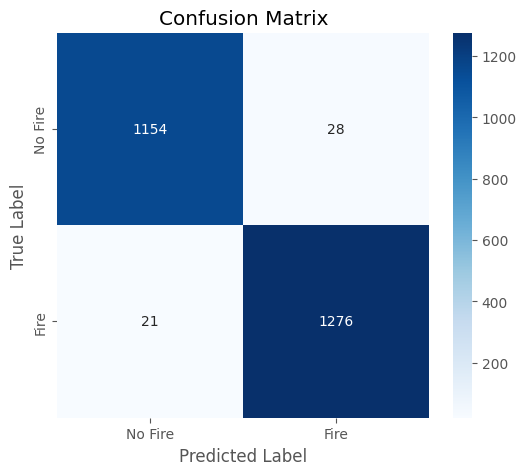

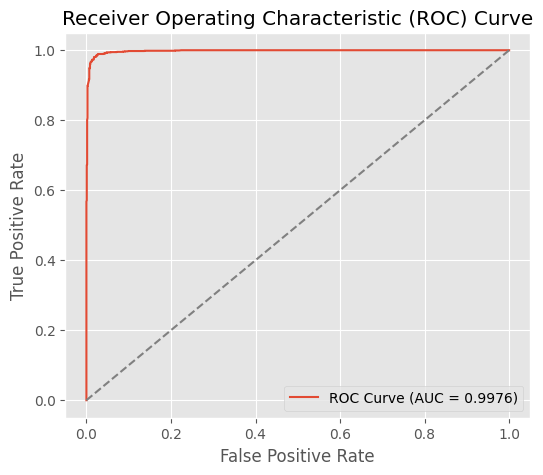

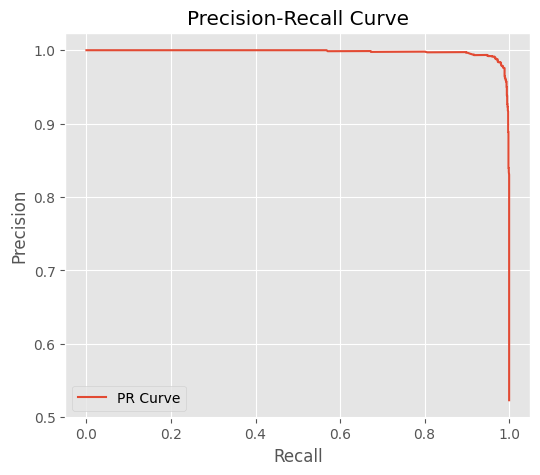

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve

# Assuming the trained model is 'stacking' (Stacked Ensemble)
# Predict probabilities for ROC & PR Curve
y_pred = stacking.predict(X_test)
y_proba = stacking.predict_proba(X_test)[:, 1]  # Probabilities for the positive class (fire occurrence)

# Compute additional metrics
conf_matrix = confusion_matrix(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)
precision, recall, _ = precision_recall_curve(y_test, y_proba)

# Print classification report
print("\n🔹 Classification Report:")
print(classification_report(y_test, y_pred))

# Print AUC Score
print(f"\n🔹 ROC-AUC Score: {roc_auc:.4f}")

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["No Fire", "Fire"], yticklabels=["No Fire", "Fire"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # Random classifier line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend()
plt.show()

# Plot Precision-Recall Curve
plt.figure(figsize=(6, 5))
plt.plot(recall, precision, label="PR Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()


In [28]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier

# Load preprocessed dataset
df = pd.read_csv("final.csv")

# Feature selection
features = ["DATE", "PRECIPITATION", "MAX_TEMP", "MIN_TEMP", "AVG_WIND_SPEED", 
            "YEAR", "TEMP_RANGE", "WIND_TEMP_RATIO", "MONTH", "SEASON", 
            "LAGGED_PRECIPITATION", "LAGGED_AVG_WIND_SPEED", "DAY_OF_YEAR"]
target = "FIRE_START_DAY"

# Convert DATE column to datetime
df["DATE"] = pd.to_datetime(df["DATE"], errors="coerce")

# Convert DATE to ordinal (days since Jan 1, 2000)
df["DATE"] = df["DATE"].map(lambda x: x.toordinal() - pd.to_datetime("2000-01-01").toordinal())

# Check if any remaining non-numeric columns exist
print(df.dtypes)


# Define X and y
X = df[features]
y = df[target]

# Split dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=42, stratify=y)

# Initialize models
models = {
    "XGBoost": XGBClassifier(n_estimators=100, learning_rate=0.05, max_depth=5, 
                             random_state=42, tree_method="hist", device="cuda"),
    
    "Random Forest": RandomForestClassifier(n_estimators=100, max_depth=10, 
                                            min_samples_split=2, min_samples_leaf=1, 
                                            random_state=42, n_jobs=-1),
    
    "LightGBM": LGBMClassifier(n_estimators=100, learning_rate=0.05, max_depth=5, 
                               num_leaves=31, random_state=42, n_jobs=-1)
}

# Train and evaluate each model
results = {}

for name, model in models.items():
    print(f"\n🔹 Training {name}...")
    
    # Train model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Evaluate performance
    accuracy = accuracy_score(y_test, y_pred)
    print(f"✅ {name} Accuracy: {accuracy:.4f}")
    print(classification_report(y_test, y_pred))
    
    # Store results
    results[name] = accuracy

# Print final comparison
print("\n📊 Model Performance Comparison:")
for model, acc in results.items():
    print(f"{model}: {acc:.4f}")



DATE                       int64
PRECIPITATION            float64
MAX_TEMP                 float64
MIN_TEMP                 float64
AVG_WIND_SPEED           float64
FIRE_START_DAY             int64
YEAR                       int64
TEMP_RANGE               float64
WIND_TEMP_RATIO          float64
MONTH                      int64
SEASON                     int64
LAGGED_PRECIPITATION     float64
LAGGED_AVG_WIND_SPEED    float64
DAY_OF_YEAR                int64
dtype: object

🔹 Training XGBoost...


C:\Users\keerthana\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:28:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
C:\Users\keerthana\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:28:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


✅ XGBoost Accuracy: 0.7870
              precision    recall  f1-score   support

           0       0.83      0.85      0.84      2002
           1       0.69      0.65      0.67       994

    accuracy                           0.79      2996
   macro avg       0.76      0.75      0.76      2996
weighted avg       0.78      0.79      0.79      2996


🔹 Training Random Forest...
✅ Random Forest Accuracy: 0.7954
              precision    recall  f1-score   support

           0       0.83      0.87      0.85      2002
           1       0.71      0.65      0.68       994

    accuracy                           0.80      2996
   macro avg       0.77      0.76      0.76      2996
weighted avg       0.79      0.80      0.79      2996


🔹 Training LightGBM...
✅ LightGBM Accuracy: 0.7917
              precision    recall  f1-score   support

           0       0.84      0.86      0.85      2002
           1       0.70      0.66      0.68       994

    accuracy                           0.

C:\Users\keerthana\AppData\Local\Temp\ipykernel_27212\288415733.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=importance_df, palette="coolwarm")


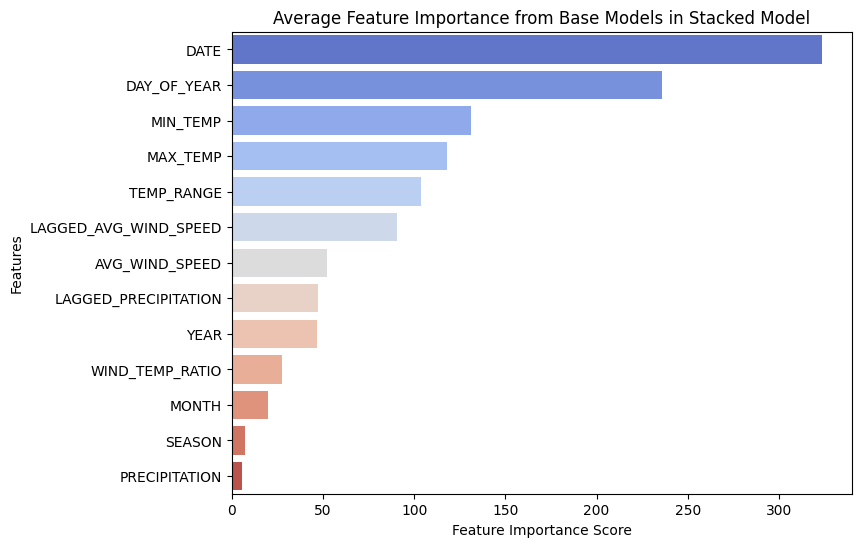

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define feature names (Ensure they match training data)
feature_names = ["DATE", "PRECIPITATION", "MAX_TEMP", "MIN_TEMP", "AVG_WIND_SPEED", "YEAR", 
                 "TEMP_RANGE", "WIND_TEMP_RATIO", "MONTH", "SEASON", "LAGGED_PRECIPITATION", 
                 "LAGGED_AVG_WIND_SPEED", "DAY_OF_YEAR"]

# Extract feature importance from base models
xgb_importance = stacking.estimators_[0].feature_importances_
rf_importance = stacking.estimators_[1].feature_importances_
lgb_importance = stacking.estimators_[2].feature_importances_

# Compute average feature importance across models
avg_importance = (xgb_importance + rf_importance + lgb_importance) / 3

# Create a DataFrame for visualization
importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": avg_importance
}).sort_values(by="Importance", ascending=False)

# Plot feature importance
plt.figure(figsize=(8, 6))
sns.barplot(x="Importance", y="Feature", data=importance_df, palette="coolwarm")

# Labels and title
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Average Feature Importance from Base Models in Stacked Model")
plt.show()


C:\Users\keerthana\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:00:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
C:\Users\keerthana\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:00:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


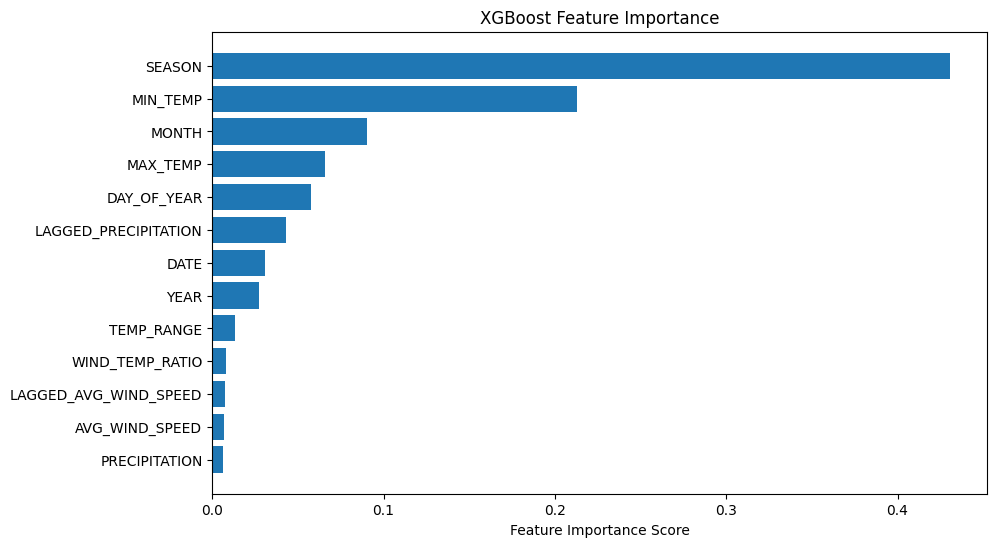

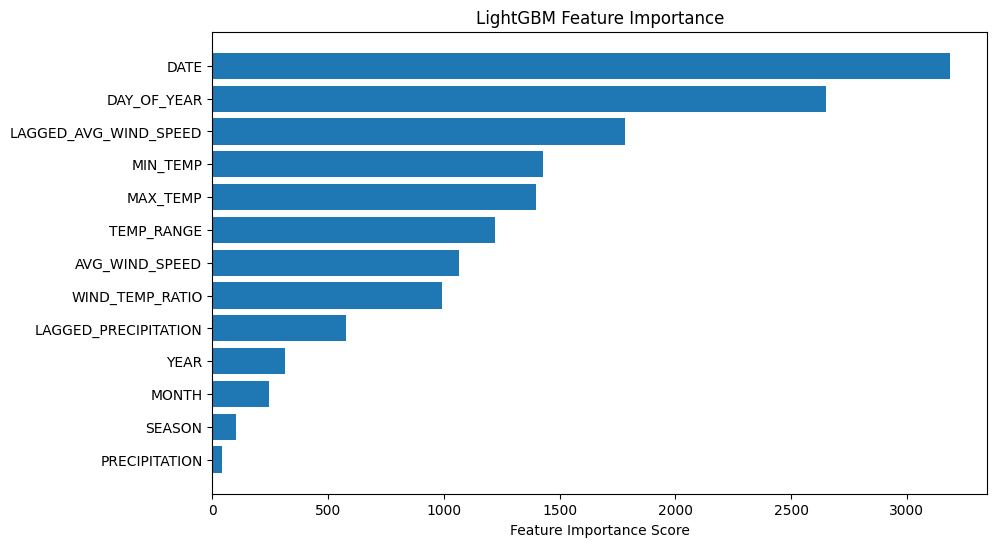

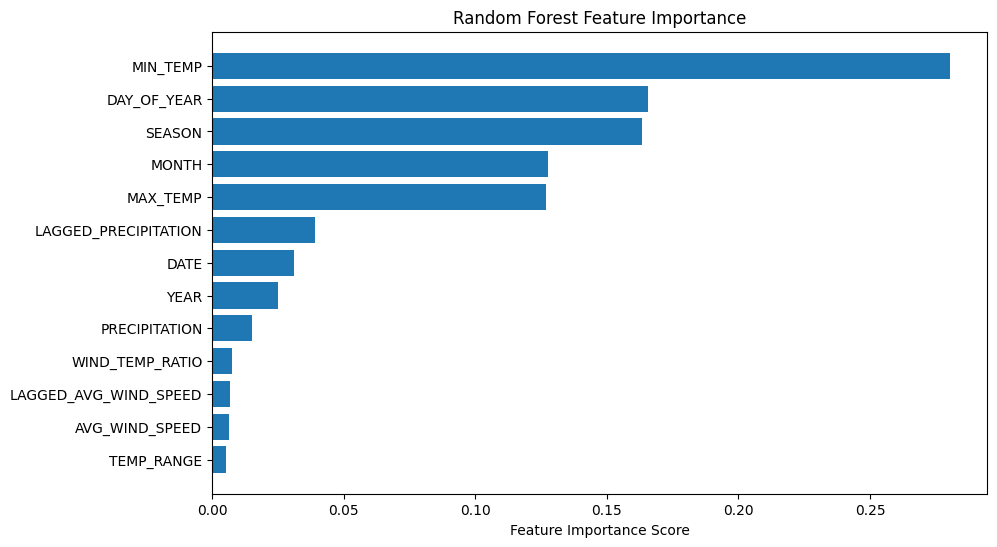

In [13]:
#shap
import matplotlib.pyplot as plt
import shap
import seaborn as sns

# Train individual models (this was missing!)
xgb.fit(X_train, y_train)
lgb.fit(X_train, y_train)
rf.fit(X_train, y_train)

# Function to plot feature importance
def plot_feature_importance(model, feature_names, title):
    importance = model.feature_importances_
    sorted_idx = np.argsort(importance)

    plt.figure(figsize=(10, 6))
    plt.barh(np.array(feature_names)[sorted_idx], importance[sorted_idx])
    plt.xlabel("Feature Importance Score")
    plt.title(title)
    plt.show()

# XGBoost Feature Importance
plot_feature_importance(xgb, X_train.columns, "XGBoost Feature Importance")

# LightGBM Feature Importance
plot_feature_importance(lgb, X_train.columns, "LightGBM Feature Importance")

# RandomForest Feature Importance
plot_feature_importance(rf, X_train.columns, "Random Forest Feature Importance")


 98%|===================| 2431/2479 [00:36<00:00]        

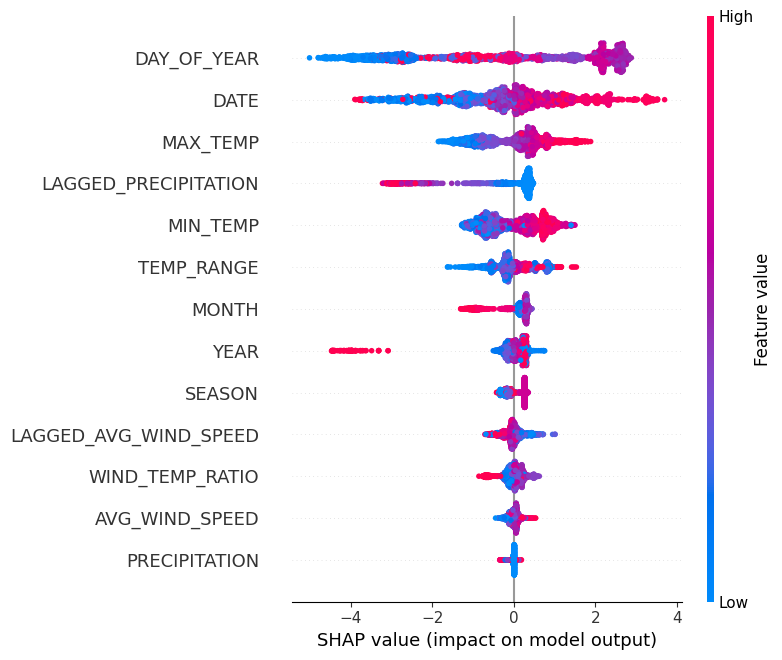

In [14]:
#shap
# SHAP for XGBoost (since it has strong feature importance)
explainer = shap.Explainer(xgb, X_train)
shap_values = explainer(X_test)

# Summary Plot (Global Feature Importance)
shap.summary_plot(shap_values, X_test)

# Force Plot (Local Explanation for a single prediction)
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0].values, X_test.iloc[0])


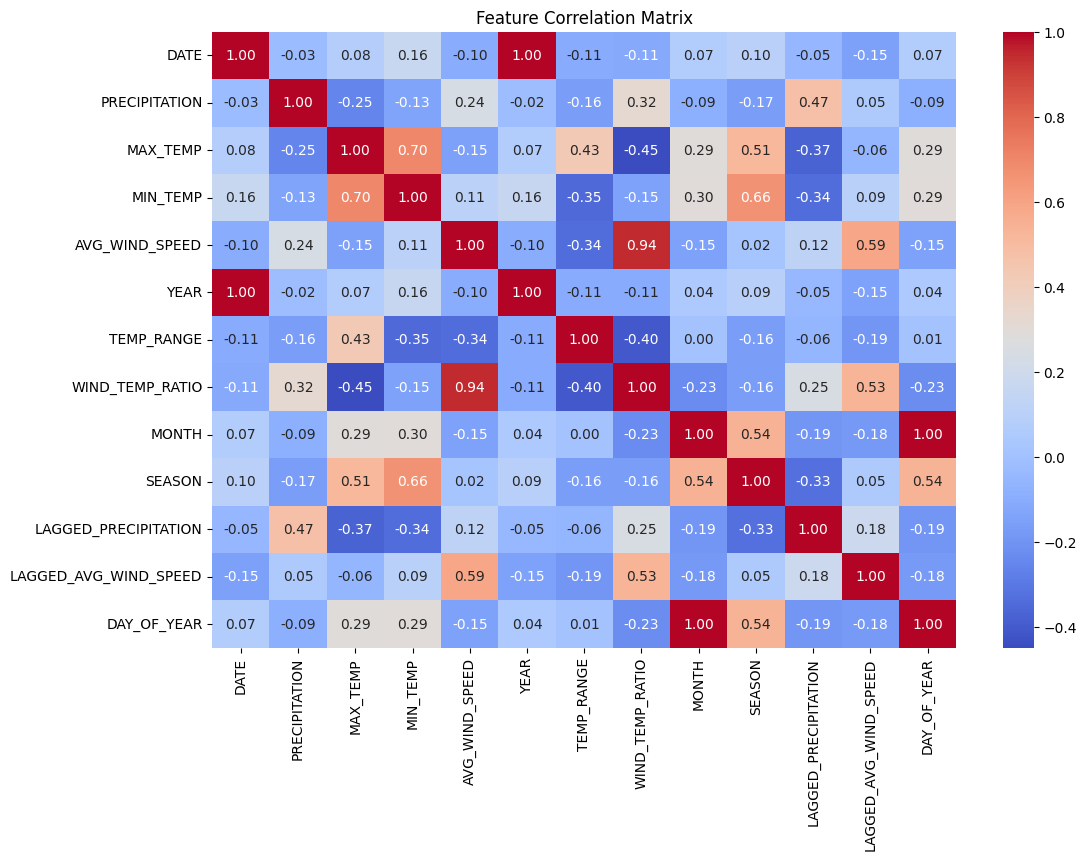

In [15]:
#shap
# Compute correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(X_train.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.show()


[I 2025-03-02 19:25:29,364] A new study created in memory with name: fire_prediction
C:\Users\keerthana\AppData\Local\Temp\ipykernel_24112\3708691272.py:11: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study)
[W 2025-03-02 19:25:29,373] There are no complete trials.
C:\Users\keerthana\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\visualization\matplotlib\_optimization_history.py:149: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(bbox_to_anchor=(1.05, 1.0), loc="upper left")


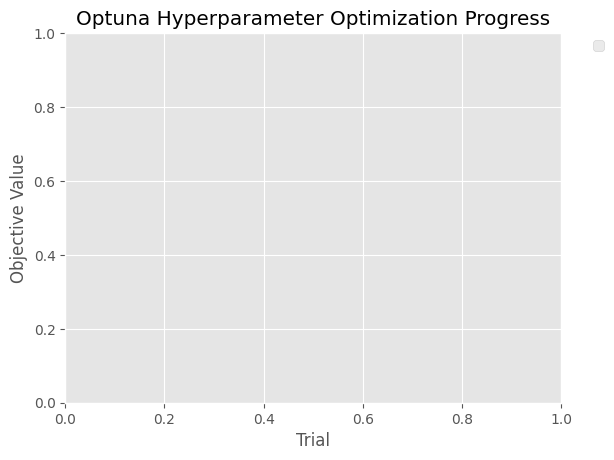

In [26]:
import optuna
import matplotlib.pyplot as plt

# Create a new study (if you haven't stored it)
study = optuna.create_study(direction="maximize", study_name="fire_prediction")

# Run hyperparameter optimization (if not already done)
# study.optimize(objective, n_trials=30)  # Uncomment this if needed

# Plot optimization history
optuna.visualization.matplotlib.plot_optimization_history(study)

# Customize plot title
plt.title("Optuna Hyperparameter Optimization Progress")

# Show the plot
plt.show()


In [17]:
import pandas as pd
import numpy as np
import optuna
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import accuracy_score, classification_report
from imblearn.combine import SMOTEENN

In [18]:


# Load dataset
df = pd.read_csv(r"final.csv")

# Feature selection
features = ["DATE", "PRECIPITATION", "MAX_TEMP", "MIN_TEMP", "AVG_WIND_SPEED", "YEAR", 
            "TEMP_RANGE", "WIND_TEMP_RATIO", "MONTH", "SEASON", "LAGGED_PRECIPITATION", 
            "LAGGED_AVG_WIND_SPEED", "DAY_OF_YEAR"]
target = "FIRE_START_DAY"

# Convert DATE to ordinal
df['DATE'] = pd.to_datetime(df['DATE'], errors='coerce')
df = df.dropna(subset=['DATE'])  # Remove NaT values
df['DATE'] = df['DATE'].map(lambda x: x.toordinal() - pd.to_datetime('2000-01-01').toordinal())

# Define X and y
X = df[features]
y = df[target]

# Handle class imbalance using SMOTEENN
smote_enn = SMOTEENN(random_state=42)
X_resampled, y_resampled = smote_enn.fit_resample(X, y)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

# Hyperparameter tuning function
def objective(trial):
    log_reg = LogisticRegression(max_iter=1000)
    
    svm_params = {
        "C": trial.suggest_float("svm_C", 0.1, 10.0),
        "kernel": trial.suggest_categorical("svm_kernel", ["linear", "rbf"])
    }
    
    knn_params = {
        "n_neighbors": trial.suggest_int("knn_n_neighbors", 3, 15),
        "weights": trial.suggest_categorical("knn_weights", ["uniform", "distance"])
    }

    svm = SVC(**svm_params)
    knn = KNeighborsClassifier(**knn_params)

    stacking = StackingClassifier(
        estimators=[('log_reg', log_reg), ('svm', svm), ('knn', knn)],
        final_estimator=LogisticRegression(),
        cv=5,
        n_jobs=-1
    )

    stacking.fit(X_train, y_train)
    y_pred = stacking.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy  

# Run Optuna hyperparameter tuning
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

# Get best parameters
best_params = study.best_params
print("Best parameters:", best_params)
print(f"Best accuracy from tuning: {study.best_value:.4f}")

# Train final models with best hyperparameters
log_reg = LogisticRegression(max_iter=1000)

svm = SVC(C=best_params["svm_C"], kernel=best_params["svm_kernel"])
knn = KNeighborsClassifier(n_neighbors=best_params["knn_n_neighbors"], weights=best_params["knn_weights"])

# Stacked ensemble classifier
stacking = StackingClassifier(
    estimators=[('log_reg', log_reg), ('svm', svm), ('knn', knn)],
    final_estimator=LogisticRegression(),
    cv=5,
    n_jobs=-1
)

# Train final model
stacking.fit(X_train, y_train)
y_pred = stacking.predict(X_test)

# Model evaluation
accuracy = accuracy_score(y_test, y_pred)
print(f"Final Accuracy: {accuracy:.4f}")
print(classification_report(y_test, y_pred))


[I 2025-03-02 14:59:05,524] A new study created in memory with name: no-name-ba60af66-6781-4488-a705-b842fa5f0665
[I 2025-03-02 14:59:29,112] Trial 0 finished with value: 0.9766034691407826 and parameters: {'svm_C': 0.18482929056003541, 'svm_kernel': 'rbf', 'knn_n_neighbors': 8, 'knn_weights': 'distance'}. Best is trial 0 with value: 0.9766034691407826.
[W 2025-03-02 15:02:58,930] Trial 1 failed with parameters: {'svm_C': 6.862338476243074, 'svm_kernel': 'linear', 'knn_n_neighbors': 9, 'knn_weights': 'uniform'} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "C:\Users\keerthana\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\study\_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\keerthana\AppData\Local\Temp\ipykernel_24112\2630902606.py", line 50, in objective
    stacking.fit(X_train, y_train)
  File "C:\Users\keerthana\AppData\Local\Programs\Pytho

KeyboardInterrupt: 

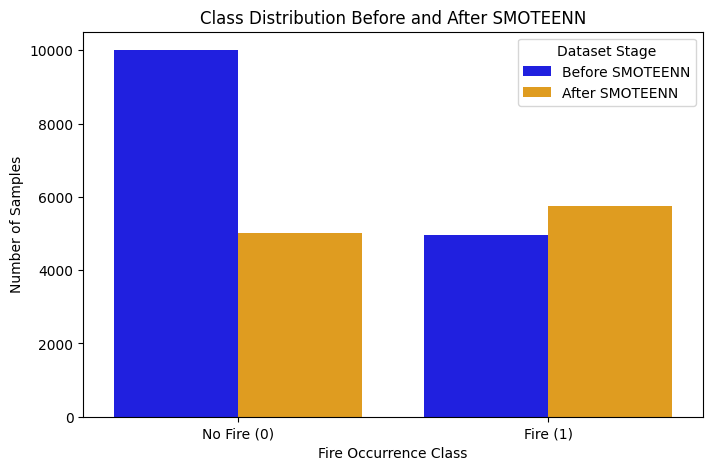

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.combine import SMOTEENN
from collections import Counter
from sklearn.model_selection import train_test_split

# Load the dataset
file_path = r"final.csv"  # Ensure this is the preprocessed dataset
df = pd.read_csv(file_path)

# Define features and target variable
features = ["PRECIPITATION", "MAX_TEMP", "MIN_TEMP", "AVG_WIND_SPEED", 
            "TEMP_RANGE", "WIND_TEMP_RATIO", "LAGGED_PRECIPITATION", "LAGGED_AVG_WIND_SPEED"]
target = "FIRE_START_DAY"

X = df[features]
y = df[target]

# Count class distribution before SMOTEENN
before_counts = Counter(y)

# Apply SMOTEENN for class balancing
smote_enn = SMOTEENN(random_state=42)
X_resampled, y_resampled = smote_enn.fit_resample(X, y)

# Count class distribution after SMOTEENN
after_counts = Counter(y_resampled)

# Create a DataFrame for visualization
class_dist_df = pd.DataFrame({
    "Class": ["No Fire (0)", "Fire (1)"] * 2,
    "Count": [before_counts[0], before_counts[1], after_counts[0], after_counts[1]],
    "Stage": ["Before SMOTEENN"] * 2 + ["After SMOTEENN"] * 2
})

# Plot the class distribution
plt.figure(figsize=(8, 5))
sns.barplot(x="Class", y="Count", hue="Stage", data=class_dist_df, palette=["blue", "orange"])

# Add labels and title
plt.xlabel("Fire Occurrence Class")
plt.ylabel("Number of Samples")
plt.title("Class Distribution Before and After SMOTEENN")
plt.legend(title="Dataset Stage")

# Show the plot
plt.show()
